In [3]:
import re
import os
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from pprint import pprint
import math

# Split speech in sentences

### Speeches to sentences with labels

In [4]:
path1 = r"Talerne\Margrethe"
path2 = r"Talerne\Statsministeren"

def sentence_and_label(path):

    sentences = {}

    for file in os.listdir(path):
        filename = os.path.join(path, file)

        # Label the sentence
        if "Margrethe" in file:
            label = 0
        else:
            label = 1

        with open(filename, encoding='utf-8') as speech:
            speech = speech.read()
        
        speech = re.sub("[,*\"'-]"," ",speech)

        speech = speech.lower()

        tokens = nltk.sent_tokenize(speech, language="danish")

        for sentence in tokens:
            sentence = re.sub("[.:;?!`–”«»%…‘’/()]"," ",sentence) 
            sentence = sentence.strip() # Uden mellemrum forrest eller bagerst
            sentences[sentence] = label
        
    return sentences

Margrethe_sentences_with_labels = sentence_and_label(path1)
Statsministeren_sentences_with_labels = sentence_and_label(path2)

In [5]:
# from pprint import pprint

# # Pretty-print to look nice
# pprint(Margrethe_sentences_with_labels)
# pprint(Statsministeren_sentences_with_labels)


In [6]:
all_sentences = Margrethe_sentences_with_labels | Statsministeren_sentences_with_labels
# pprint(all_sentences)
print(len(all_sentences))

10731


In [7]:
# Inspect the tokens that look suspicious
for sentence in all_sentences:
    tokens = word_tokenize(sentence)
    # Look for weird tokens
    weird_tokens = [t for t in tokens if not t.isalnum()]
    if weird_tokens:
        print("Weird tokens found:", weird_tokens)

### Separate keys and values into two lists (For vectorization)

In [8]:
sentences_list = []
labels_list = []

for sentence in all_sentences:
    sentences_list.append(sentence)
    labels_list.append(all_sentences[sentence])

print(sentences_list)
print(labels_list)

['for min familie og for mig selv blev dette år skelsættende ved min fader kong frederiks sygdom og død', 'den dybe sorg  der ramte os  følte vi  at hele folket tog del i  og jeg kan ikke begynde denne min første nytårshilsen uden at bringe en tak for al den varme og sympati  som blev prins henrik og mig  men ikke mindst min moder  dronning ingrid  til del', 'de hjertelige følelser  som i de tunge dage støttede og løftede os  har jeg siden i årets løb mødt så mange gange  og det har været mig en glæde og inspiration i min gerning som danmarks dronning', '1972 vil blive et historisk år på mange måder', 'i danmarkshistorien vil året blive husket for den betydningsfulde beslutning  som det danske folk traf om danmarks medlemskab af det udvidede europæiske fællesskab', 'hermed træder vi ind i et nært samarbejde med de vigtigste vesteuropæiske nationer  vi går ind til det med store forhåbninger  men selvsagt også med en bevidsthed om  at dette vil stille krav til dansk kultur  og samfundsli

In [9]:
print(len(sentences_list))

10731


# UNIGRAM

In [10]:
unigram_dict = {}
unigram_set = set()
unigram_nt = {}

for sentence in sentences_list:
    # tokens i den givne sætning
    sentence_tokens = [word for word in word_tokenize(sentence)]

    # hvilke unigrams, der er blevet set i den givne sætning
    seen_unigrams = set()

    for unigram in sentence_tokens:
        if unigram in unigram_set:
            unigram_dict[unigram] += 1
        else:
            unigram_dict[unigram] = 1
            unigram_set.add(unigram)
    
        # Udregn nt - dvs antal af alle sætninger, der indeholder det givne unigram
        if unigram not in seen_unigrams:
            if unigram not in unigram_nt:
                unigram_nt[unigram] = 1
            else:
                unigram_nt[unigram] += 1
            seen_unigrams.add(unigram)

print(len(unigram_dict))
print(unigram_nt)

11591
{'for': 2413, 'min': 223, 'familie': 118, 'og': 4156, 'mig': 203, 'selv': 390, 'blev': 235, 'dette': 105, 'år': 880, 'skelsættende': 8, 'ved': 489, 'fader': 4, 'kong': 6, 'frederiks': 3, 'sygdom': 28, 'død': 12, 'den': 1350, 'dybe': 12, 'sorg': 15, 'der': 1802, 'ramte': 10, 'os': 1116, 'følte': 13, 'vi': 3651, 'at': 3217, 'hele': 247, 'folket': 5, 'tog': 28, 'del': 133, 'i': 3580, 'jeg': 1096, 'kan': 1171, 'ikke': 1527, 'begynde': 23, 'denne': 128, 'første': 86, 'nytårshilsen': 49, 'uden': 161, 'bringe': 59, 'en': 1825, 'tak': 182, 'al': 43, 'varme': 55, 'sympati': 7, 'som': 1489, 'prins': 48, 'henrik': 12, 'men': 1135, 'mindst': 87, 'moder': 11, 'dronning': 27, 'ingrid': 9, 'til': 2129, 'de': 1835, 'hjertelige': 8, 'følelser': 9, 'tunge': 15, 'dage': 50, 'støttede': 3, 'løftede': 2, 'har': 1814, 'siden': 126, 'årets': 54, 'løb': 29, 'mødt': 33, 'så': 886, 'mange': 612, 'gange': 30, 'det': 3866, 'været': 204, 'glæde': 112, 'inspiration': 12, 'gerning': 16, 'danmarks': 70, '1972':

In [11]:
# pprint(unigram_dict)

In [12]:
unigram_dict_forkortet = {}

# adder kun de unigrams, der er blevet talt mere end 1 gang.
for unigram in unigram_dict.keys():
    if unigram_dict[unigram] > 1:
        unigram_dict_forkortet[unigram] = unigram_dict[unigram] 

# unigram_dict_forkortet

In [13]:
len(unigram_dict_forkortet)

5590

# BIGRAM

In [14]:
bigram_dict = {}
bigram_set = set()
bigram_nt = {}

# print(bigram_nt)

for sentence in sentences_list:
    sentence_tokens = [word for word in word_tokenize(sentence)]
    seen_bigrams = set()

    for i in range(len(sentence_tokens)-1):
        bigram = sentence_tokens[i] + ' ' + sentence_tokens[i+1]
        if bigram in bigram_set:
            bigram_dict[bigram] += 1
        else:
            bigram_dict[bigram] = 1
            bigram_set.add(bigram)
    
    # Udregn nt
        if bigram not in seen_bigrams:
            if bigram not in bigram_nt:
                bigram_nt[bigram] = 1
            else:
                bigram_nt[bigram] += 1
            seen_bigrams.add(bigram)

print(bigram_nt)

{'for min': 13, 'min familie': 49, 'familie og': 31, 'og for': 106, 'for mig': 33, 'mig selv': 8, 'selv blev': 4, 'blev dette': 1, 'dette år': 14, 'år skelsættende': 1, 'skelsættende ved': 1, 'ved min': 2, 'min fader': 2, 'fader kong': 1, 'kong frederiks': 1, 'frederiks sygdom': 1, 'sygdom og': 6, 'og død': 2, 'den dybe': 1, 'dybe sorg': 1, 'sorg der': 2, 'der ramte': 1, 'ramte os': 1, 'os følte': 1, 'følte vi': 5, 'vi at': 34, 'at hele': 3, 'hele folket': 1, 'folket tog': 1, 'tog del': 2, 'del i': 16, 'i og': 11, 'og jeg': 119, 'jeg kan': 27, 'kan ikke': 63, 'ikke begynde': 2, 'begynde denne': 2, 'denne min': 1, 'min første': 2, 'første nytårshilsen': 2, 'nytårshilsen uden': 1, 'uden at': 47, 'at bringe': 8, 'bringe en': 6, 'en tak': 49, 'tak for': 99, 'for al': 15, 'al den': 16, 'den varme': 13, 'varme og': 18, 'og sympati': 2, 'sympati som': 2, 'som blev': 9, 'blev prins': 1, 'prins henrik': 11, 'henrik og': 10, 'og mig': 23, 'mig men': 1, 'men ikke': 14, 'ikke mindst': 82, 'mindst 

In [15]:
len(bigram_dict)

60904

In [16]:
# bigram_dict

In [17]:
bigram_dict_forkortet = {}

for bigram in bigram_dict.keys():
    if bigram_dict[bigram] > 1:
        bigram_dict_forkortet[bigram] = bigram_dict[bigram] 

# bigram_dict_forkortet

In [18]:
len(bigram_dict_forkortet)

15268

# TRIGRAM

In [19]:
trigram_dict = {}
trigram_set = set()
trigram_nt = {}

for sentence in sentences_list:
    sentence_tokens = [word for word in word_tokenize(sentence)]
    seen_trigrams = set()

    for i in range(len(sentence_tokens)-2):
        trigram = sentence_tokens[i] + ' ' + sentence_tokens[i+1] + ' ' + sentence_tokens[i+2]
        if trigram in trigram_set:
            trigram_dict[trigram] += 1
        else:
            trigram_dict[trigram] = 1
            trigram_set.add(trigram)

        # udregn nt
        if trigram not in seen_trigrams:
            if trigram not in trigram_nt:
                trigram_nt[trigram] = 1
            else:
                trigram_nt[trigram] += 1
            seen_trigrams.add(trigram)


# print(trigram_nt)

In [20]:
# trigram_dict

In [21]:
len(trigram_dict) # finder 4000 flere trigrams end sklearn???

100929

In [22]:
trigram_dict_forkortet = {}

for trigram in trigram_dict.keys():
    if trigram_dict[trigram] > 1:
        trigram_dict_forkortet[trigram] = trigram_dict[trigram] 

# trigram_dict_forkortet

In [23]:
len(trigram_dict_forkortet)

11560

# ALLE I ÉN LISTE

In [24]:
len(unigram_dict_forkortet) + len(bigram_dict_forkortet) + len(trigram_dict_forkortet)

32418

In [25]:
n_gram_dict = unigram_dict_forkortet | bigram_dict_forkortet | trigram_dict_forkortet

In [26]:
# pprint(n_gram_dict)

In [27]:
len(n_gram_dict)

32418

In [28]:
alle_nt = unigram_nt | bigram_nt | trigram_nt

# Document-term matrix:

In [29]:
n_gram_keys_list = [key for key in n_gram_dict.keys()]

In [30]:
# sentences_list

In [31]:
document_term_matrix = np.empty((len(sentences_list),len(n_gram_keys_list)),dtype='uint8')

for i in range(len(sentences_list)):
    for j in range(len(n_gram_keys_list)):
        count = sentences_list[i].count(n_gram_keys_list[j])
        document_term_matrix[i,j] = count
        
document_term_matrix

KeyboardInterrupt: 

In [260]:
document_term_matrix.shape

(10731, 32418)

In [ ]:
# document_term_matrix.to_string()

In [258]:
document_term_matrix_df = df = pd.DataFrame(data = document_term_matrix,  
                  index = sentences_list,  
                  columns = n_gram_keys_list) 
document_term_matrix_df

,for,min,familie,og,mig,selv,blev,dette,år,skelsættende,...,de befolkninger i,befolkninger i verden,uanset hvad der,er historien om,vi bevæger os,bevæger os fremad,med de seneste,og hvis du,man siger at,år vil byde
for min familie og for mig selv blev dette år skelsættende ved min fader kong frederiks sygdom og død,2,2,1,2,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
den dybe sorg der ramte os følte vi at hele folket tog del i og jeg kan ikke begynde denne min første nytårshilsen uden at bringe en tak for al den varme og sympati som blev prins henrik og mig men ikke mindst min moder dronning ingrid til del,1,3,0,4,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
de hjertelige følelser som i de tunge dage støttede og løftede os har jeg siden i årets løb mødt så mange gange og det har været mig en glæde og inspiration i min gerning som danmarks dronning,0,1,0,3,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1972 vil blive et historisk år på mange måder,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
i danmarkshistorien vil året blive husket for den betydningsfulde beslutning som det danske folk traf om danmarks medlemskab af det udvidede europæiske fællesskab,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jeg tror desværre at de kommende år vil byde på flere trusler mod vores land og levevis,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
oprustning for at undgå krig er i mine øjne uomgængeligt,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
men lad os gøre det på den danske måde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
socialt retfærdigt og med vores værdier i behold,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TF-IDF matrix:

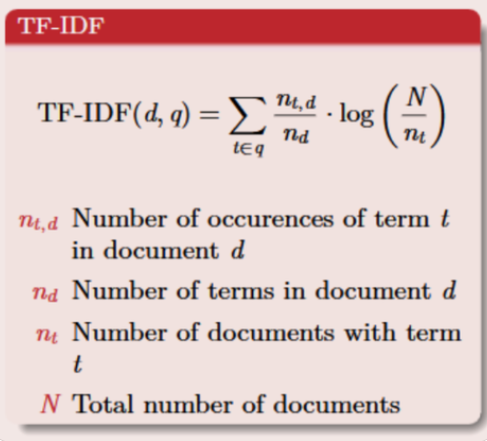

In [ ]:
document_term_idf_matrix = np.empty((len(sentences_list),len(n_gram_keys_list)),dtype='uint8')

for i in range(len(sentences_list)):
    for j in range(len(n_gram_keys_list)):
        term = n_gram_keys_list[j]
        ntd = sentences_list[i].count(term)
        nd = len(sentences_list[i])
        nt = alle_nt[term]

        document_term_idf_matrix[i, j] = (ntd/nd) * math.log(len(sentences_list)/nt)

document_term_idf_matrix

In [ ]:
document_term_idf_matrix.shape

NameError: name 'document_term_idf_matrix' is not defined

In [ ]:
document_term_idf_matrix.to_string()

In [292]:
document_term_idf_matrix_df = df = pd.DataFrame(data = document_term_idf_matrix,  
                  index = sentences_list,  
                  columns = n_gram_keys_list) 
document_term_idf_matrix

,for,min,familie,og,mig,selv,blev,dette,år,skelsættende,...,de befolkninger i,befolkninger i verden,uanset hvad der,er historien om,vi bevæger os,bevæger os fremad,med de seneste,og hvis du,man siger at,år vil byde
for min familie og for mig selv blev dette år skelsættende ved min fader kong frederiks sygdom og død,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
den dybe sorg der ramte os følte vi at hele folket tog del i og jeg kan ikke begynde denne min første nytårshilsen uden at bringe en tak for al den varme og sympati som blev prins henrik og mig men ikke mindst min moder dronning ingrid til del,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
de hjertelige følelser som i de tunge dage støttede og løftede os har jeg siden i årets løb mødt så mange gange og det har været mig en glæde og inspiration i min gerning som danmarks dronning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1972 vil blive et historisk år på mange måder,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i danmarkshistorien vil året blive husket for den betydningsfulde beslutning som det danske folk traf om danmarks medlemskab af det udvidede europæiske fællesskab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jeg tror desværre at de kommende år vil byde på flere trusler mod vores land og levevis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
oprustning for at undgå krig er i mine øjne uomgængeligt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
men lad os gøre det på den danske måde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
socialt retfærdigt og med vores værdier i behold,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
